In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ['VXM_BACKEND'] = 'pytorch'
import ddmreg
import glob
import pathlib

In [18]:
toms = list(pathlib.Path('.').glob('**/tom'))
len(list(toms[0].iterdir()))


41

[PosixPath('test/sub_1/tom'), PosixPath('test/sub_2/tom')]

In [2]:

model = ddmreg.networks.DDMReg_dMRI_TOMs_reorient_mem.load(os.path.join('ddmreg_models', 'ddmreg_model_fa_ep0750.pt'), 'cpu')

/Users/wangjunyi/miniforge3/envs/py39t/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
targetDir = 'test/sub_1/'
movingDir = 'test/sub_2/'

In [4]:
target_fa   = sorted(glob.glob(os.path.join(targetDir, '*_fa.nii.gz')))
moving_fa   = sorted(glob.glob(os.path.join(movingDir, '*_fa.nii.gz')))

In [5]:
target_vol = torch.from_numpy(ddmreg.utils.load_volfile(target_fa[0]))
moving_vol = torch.from_numpy(ddmreg.utils.load_volfile(moving_fa[0]))


In [6]:
flow  = torch.load('test/sub_1-TO-sub_2/flow.pt',map_location=torch.device('cpu'))

In [7]:
flow.shape

torch.Size([1, 3, 64, 80, 64])

In [8]:
target_vol.shape

torch.Size([128, 160, 128])

In [9]:
fa_wraped = ddmreg.utils.load_volfile('test/sub_1-TO-sub_2/fa_warped.nii.gz')

In [10]:
model.tract_tom_model_names = None

In [11]:
model.eval()
y_src,flow,_,_ = model(moving_vol.unsqueeze(0).unsqueeze(0),target_vol.unsqueeze(0).unsqueeze(0),registration=True)

torch.Size([1, 3, 128, 160, 128])


In [12]:
with torch.no_grad():
    y_src1=torch.cat([y_src for _ in range(3)],dim=1)
    a = model.reorienter(y_src1,flow)

torch.Size([1, 3, 128, 160, 128])
torch.Size([128, 160, 128, 3, 3])


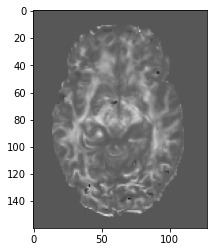

In [13]:
plt.imshow(np.flip(a.squeeze().detach().numpy()[1,...,50].T), cmap='gray')

In [19]:
flow.shape

torch.Size([1, 3, 64, 80, 64])

In [24]:
src = torch.ones((10, 3, 128, 160, 128))
# flow = torch.rand((10, 3,128,160,128))
model.reorienter(src,flow)

RuntimeError: The size of tensor a (128) must match the size of tensor b (64) at non-singleton dimension 4

In [2]:
backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
                   'CG', 'CST', 'FPT', 'FX', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP',
                   'SLF_I', 'SLF_II', 'SLF_III', 'STR',
                   'ST_FO', 'ST_OCC', 'ST_PAR', 'ST_POSTC', 'ST_PREC', 'ST_PREF', 'ST_PREM',
                   'T_OCC', 'T_PAR', 'T_POSTC', 'T_PREC', 'T_PREF', 'T_PREM', 'UF']

In [13]:
k = torch.rand((5,15,20))
f = lambda x: (x**2).sum(-1)
torch.vmap(torch.func.jacrev(f))(k).shape
# torch.vmap(f)(k).shape,f(k).shape

torch.Size([5, 15, 15, 20])

In [46]:
x,y,z = torch.meshgrid([torch.arange(v) for v in (128,128,128)],indexing = 'xy')

In [99]:
flow = torch.rand((10,3,128,128,128))
grids = torch.stack((x,y,z))/128+flow

In [100]:
grids.shape

torch.Size([10, 3, 128, 128, 128])

In [101]:
gridJs1 = torch.vmap(torch.gradient)(grids)
torch.cat(gridJs1).shape
# gridJs1[2][:,1,...]

torch.Size([40, 3, 128, 128, 128])

In [62]:
torch.vmap(torch.vmap(torch.gradient))(torch.rand((1,3,3)))

(tensor([[[ 0.5021,  0.0644, -0.3732],
          [ 0.6797,  0.0834, -0.5130],
          [ 0.7800,  0.3940,  0.0079]]]),)

In [32]:
gridJs2 = torch.autograd.grad(grids)

5

In [71]:
a = torch.rand((10,50,100))
u,s,v = torch.svd(a,)

In [88]:
torch.matmul(u,torch.transpose(v,1,2))[5].max()

tensor(0.2623)

In [76]:
u.shape,v.shape

(torch.Size([10, 50, 50]),
 torch.Size([10, 100, 50]),
 torch.Size([50, 100, 10]))